In [1]:
#Imports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot

import loompy
from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment, Trinarizer
from cytograph.manifold import GraphSkeletonizer
from typing import *

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def corr2_coeff(A, B):
    # Calculate columnwise meat mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [162]:
# f_atac = '/data/proj/scATAC/chromograph/build_20200511/Midbrain/Midbrain_GA2.agg.loom'
f_atac_agg = '/data/proj/scATAC/chromograph/build_20200511/All/All_GA.agg.loom'
f_atac = '/data/proj/scATAC/chromograph/build_20200511/All/All_GA.loom'

# f_rna = '/proj/human_development/Regions_20200225/data/MidbrainV2.agg.loom'
f_rna_agg = '/proj/human_development/wholebrain_harmony/data/Allbrain.agg.loom'

16:14:43 INFO     Overlapping marker genes are 1087 for 7356 rna markers and 3368 atac markers
16:14:45 INFO     Calculating correlation
16:14:45 INFO     Get RNA markers and AutoAnnotation
16:14:45 INFO     Mapped 62 atac clusters to 8 RNA clusters


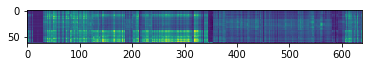

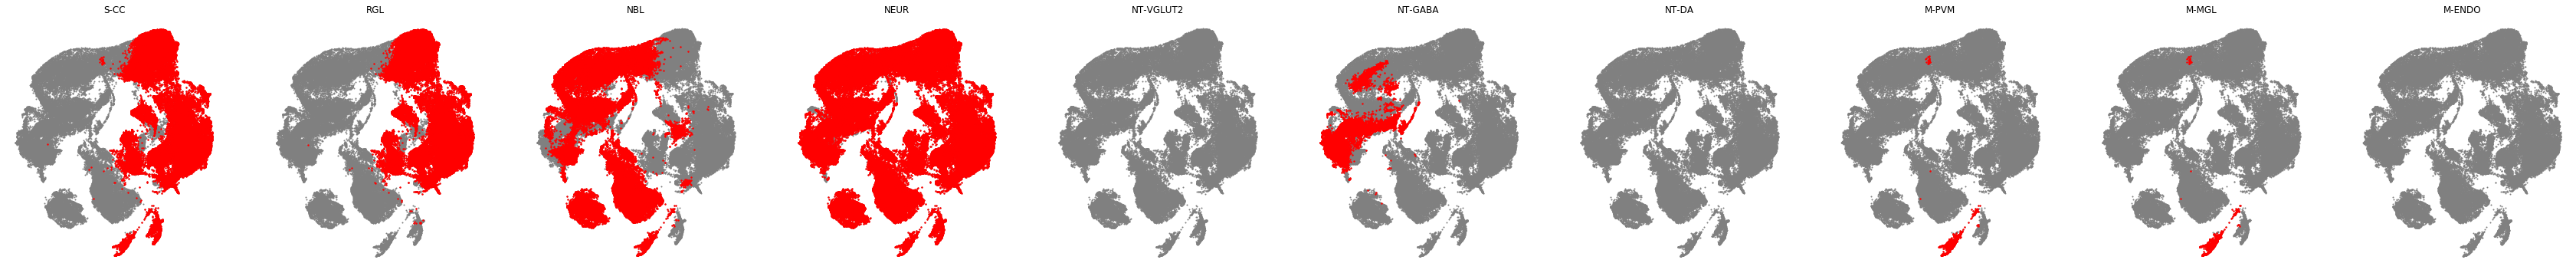

In [218]:
N_align = 100

with loompy.connect(f_atac_agg, 'r+') as dsa:
    with loompy.connect(f_rna_agg, 'r') as dsr:
        atac_genes = [dsa.ra.Gene[dsa['enrichment'][:,i].argsort()[::-1][:N_align]].tolist() for i in range(dsa.shape[1])]
        atac_genes = np.unique([x for s in atac_genes for x in s])
        
        rna_genes = [dsr.ra.Gene[dsr['enrichment'][:,i].argsort()[::-1][:N_align]].tolist() for i in range(dsr.shape[1])]
        rna_genes = np.unique([x for s in rna_genes for x in s])
        
        intersection = [gene for gene in atac_genes if gene in rna_genes]
        
        logging.info(f'Overlapping marker genes are {len(intersection)} for {len(rna_genes)} rna markers and {len(atac_genes)} atac markers')
        
        atac = np.zeros((len(intersection), dsa.shape[1]))
        rna = np.zeros((len(intersection), dsr.shape[1]))
        
        gene_list = []
        mat = []
        for ds in [dsa, dsr]:
            valid = [gene in intersection for gene in ds.ra.Gene]
            data = ds[:,:][valid,:]
            
            ## Reorder
            genes = ds.ra.Gene[valid]
            idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(genes))]
            
            data = data[idx,:]
            genes = genes[idx]
            
            ## Check for duplicate annotations, in most cases the duplicates value is zero
            cnt = Counter(genes)
            dups = [k for k, v in cnt.items() if v > 1]
            
            ## Sum duplicate gene names and remove extra rows
            for dup in dups:
                x = np.where(genes == dup)[0]
                data[x[0],:] = np.sum(data[x,:], axis=0)
                data = np.delete(data, x[1:], axis=0)
                genes = np.delete(genes, x[1:])
                
            mat.append(data)
            gene_list.append(genes)
            
        logging.info(f'Calculating correlation')
        cor = corr2_coeff(mat[0].T, mat[1].T)
        plt.imshow(cor)
        
        logging.info(f'Get RNA markers and AutoAnnotation')
        RNA_autoannot = []
        RNA_markers = []
        for i in range(cor.shape[0]):
            RNA_autoannot.append(dsr.ca.AutoAnnotation[np.argmax(cor[i,:])])
            RNA_markers.append(dsr.ca.MarkerGenes[np.argmax(cor[i,:])])
        logging.info(f'Mapped {dsa.shape[1]} atac clusters to {len(np.unique(RNA_markers))} RNA clusters')

## List the annotation terms
annots = [x.split(' ') for x in RNA_autoannot]

with loompy.connect(f_atac, 'r+') as dsa:
    
    emb = 'UMAP'
    terms = ['S-CC', 'RGL', 'NBL', 'NEUR', 'NT-VGLUT2', 'NT-GABA', 'NT-DA', 'M-PVM', 'M-MGL', 'M-ENDO']
    fig, ax = plt.subplots(1, len(terms), figsize=(6*len(terms), 6))
    
    for i, t in enumerate(terms):

        ## Get clusters
        v = [t in x for x in annots]
        c = np.where(v)[0]
        valid = [x in c for x in dsa.ca.Clusters]

        ## UMAP
        ax[i].scatter(dsa.ca[emb][:,0], dsa.ca[emb][:,1], s = 1, c = 'gray')
        ax[i].scatter(dsa.ca[emb][valid,0], dsa.ca[emb][valid,1], s = 2, c = 'red')
        ax[i].set_title(f'{t}')
        ax[i].axis("off")

In [219]:
# f_atac = '/data/proj/scATAC/chromograph/build_20200511/Midbrain/Midbrain_GA2.agg.loom'
f_atac_agg = '/data/proj/scATAC/chromograph/build_20200511/Midbrain/Midbrain_GA.agg.loom'
f_atac = '/data/proj/scATAC/chromograph/build_20200511/Midbrain/Midbrain_GA.loom'

f_rna = '/proj/human_development/Regions_20200225/data/MidbrainV2.agg.loom'
# f_rna_agg = '/proj/human_development/wholebrain_harmony/data/Allbrain.agg.loom'

In [222]:
N_align = 100

with loompy.connect(f_atac_agg, 'r+') as dsa:
    with loompy.connect(f_rna_agg, 'r') as dsr:
        atac_genes = [dsa.ra.Gene[dsa['enrichment'][:,i].argsort()[::-1][:N_align]].tolist() for i in range(dsa.shape[1])]
        atac_genes = np.unique([x for s in atac_genes for x in s])
        
        rna_genes = [dsr.ra.Gene[dsr['enrichment'][:,i].argsort()[::-1][:N_align]].tolist() for i in range(dsr.shape[1])]
        rna_genes = np.unique([x for s in rna_genes for x in s])
        
        intersection = [gene for gene in atac_genes if gene in rna_genes]
        
        logging.info(f'Overlapping marker genes are {len(intersection)} for {len(rna_genes)} rna markers and {len(atac_genes)} atac markers')
        
        atac = np.zeros((len(intersection), dsa.shape[1]))
        rna = np.zeros((len(intersection), dsr.shape[1]))
        
        gene_list = []
        mat = []
        for ds in [dsa, dsr]:
            valid = [gene in intersection for gene in ds.ra.Gene]
            data = ds[:,:][valid,:]
            
            ## Reorder
            genes = ds.ra.Gene[valid]
            idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(genes))]
            
            data = data[idx,:]
            genes = genes[idx]
            
            ## Check for duplicate annotations, in most cases the duplicates value is zero
            cnt = Counter(genes)
            dups = [k for k, v in cnt.items() if v > 1]
            
            ## Sum duplicate gene names and remove extra rows
            for dup in dups:
                x = np.where(genes == dup)[0]
                data[x[0],:] = np.sum(data[x,:], axis=0)
                data = np.delete(data, x[1:], axis=0)
                genes = np.delete(genes, x[1:])
                
            mat.append(data)
            gene_list.append(genes)
            
        logging.info(f'Calculating correlation')
        cor = corr2_coeff(mat[0].T, mat[1].T)
        plt.imshow(cor)
        
        logging.info(f'Get RNA markers and AutoAnnotation')
        RNA_autoannot = []
        RNA_markers = []
        for i in range(cor.shape[0]):
            RNA_autoannot.append(dsr.ca.AutoAnnotation[np.argmax(cor[i,:])])
            RNA_markers.append(dsr.ca.MarkerGenes[np.argmax(cor[i,:])])
        logging.info(f'Mapped {dsa.shape[1]} atac clusters to {len(np.unique(RNA_markers))} RNA clusters')

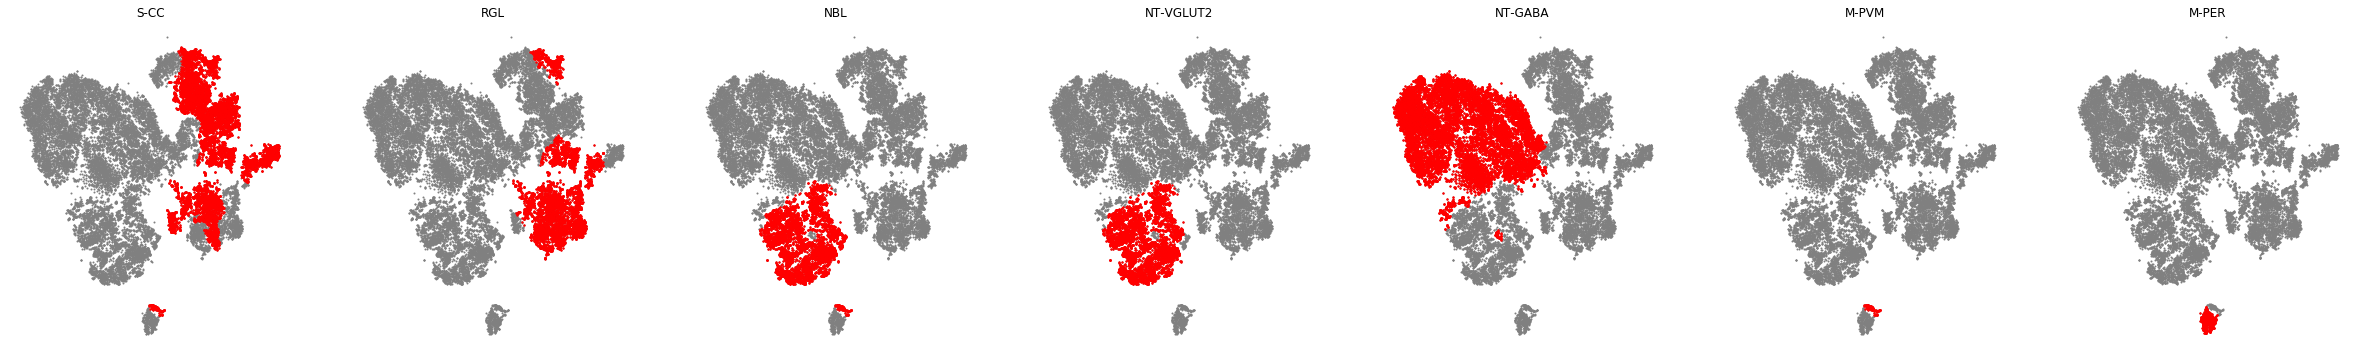

In [228]:
## List the annotation terms
annots = [x.split(' ') for x in RNA_autoannot]

with loompy.connect(f_atac, 'r+') as dsa:
    
    emb = 'TSNE'
    terms = ['S-CC', 'RGL', 'NBL', 'NT-VGLUT2', 'NT-GABA', 'M-PVM', 'M-PER']
    fig, ax = plt.subplots(1, len(terms), figsize=(6*len(terms), 6))
    
    for i, t in enumerate(terms):

        ## Get clusters
        v = [t in x for x in annots]
        c = np.where(v)[0]
        valid = [x in c for x in dsa.ca.Clusters]

        ## UMAP
        ax[i].scatter(dsa.ca[emb][:,0], dsa.ca[emb][:,1], s = 1, c = 'gray')
        ax[i].scatter(dsa.ca[emb][valid,0], dsa.ca[emb][valid,1], s = 2, c = 'red')
        ax[i].set_title(f'{t}')
        ax[i].axis("off")
    plt.savefig('/home/camiel/misc/midbrain_labels.png')

In [223]:
for i , annot in enumerate(zip(RNA_autoannot, RNA_markers)):
    print(i, annot)

0 ('NBL', 'NEUROG1 DNAJC12 GREM2 KLHDC8A GPRIN3 PHTF1')
1 ('NBL NT-VGLUT2', 'FEZF1 TFAP2A DMRTA1 BTBD11 KLHL14 ZBTB16')
2 ('NBL NEUR NP-TRH NT-VGLUT2', 'FSTL4 NR4A2 XIST CNTN5 SPON2 RASGEF1C')
3 ('NBL NT-VGLUT2', 'FEZF1 TFAP2A DMRTA1 BTBD11 KLHL14 ZBTB16')
4 ('NBL NT-VGLUT2', 'FEZF1 TFAP2A DMRTA1 BTBD11 KLHL14 ZBTB16')
5 ('NBL NT-VGLUT2', 'GNG8 FBXO2 VWA5A AC007091.1 RAP1GAP2 DPYD-AS1')
6 ('NBL NT-VGLUT2', 'GNG8 FBXO2 VWA5A AC007091.1 RAP1GAP2 DPYD-AS1')
7 ('NBL NT-VGLUT2', 'GNG8 FBXO2 VWA5A AC007091.1 RAP1GAP2 DPYD-AS1')
8 ('NBL NEUR NP-TRH NT-VGLUT2', 'FSTL4 NR4A2 XIST CNTN5 SPON2 RASGEF1C')
9 ('NT-GABA', 'PAX5 RPP25 NXPH1 POU6F2 DOC2B SOX21')
10 ('NEUR NP-TRH NT-GABA', 'LINC01210 EPHA8 NXPH1 KIZ SOX21-AS1 SOX21')
11 ('NEUR NP-TRH NT-GABA', 'LINC01210 EPHA8 NXPH1 KIZ SOX21-AS1 SOX21')
12 ('NEUR NP-TRH NT-GABA', 'LINC01210 EPHA8 NXPH1 KIZ SOX21-AS1 SOX21')
13 ('NEUR NP-TRH NT-GABA', 'LINC01210 EPHA8 NXPH1 KIZ SOX21-AS1 SOX21')
14 ('NEUR NP-TRH NT-GABA', 'LINC01210 EPHA8 NXPH1 KIZ SOX2

In [31]:
f_atac_agg = '/data/proj/scATAC/chromograph/build_20200611/Cerebellum/Cerebellum_GA.agg.loom'
f_atac = '/data/proj/scATAC/chromograph/build_20200611/Cerebellum/Cerebellum_GA.loom'

f_rna_agg = '/proj/human_development/Regions_20200225/data/CerebellumV2.agg.loom'
# f_rna_agg = '/proj/human_development/wholebrain_harmony/data/Allbrain.agg.loom'

18:40:16 INFO     Overlapping marker genes are 246 for 2994 rna markers and 1746 atac markers
18:40:16 INFO     Calculating correlation
18:40:16 INFO     Get RNA markers and AutoAnnotation
18:40:16 INFO     Mapped 29 atac clusters to 8 RNA clusters


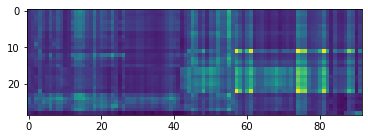

In [53]:
# N_align = 40
N_align = 75

with loompy.connect(f_atac_agg, 'r+') as dsa:
    with loompy.connect(f_rna_agg, 'r') as dsr:
        atac_genes = [dsa.ra.Gene[dsa['enrichment'][:,i].argsort()[::-1][:N_align]].tolist() for i in range(dsa.shape[1])]
        atac_genes = np.unique([x for s in atac_genes for x in s])
        
        rna_genes = [dsr.ra.Gene[dsr['enrichment'][:,i].argsort()[::-1][:N_align]].tolist() for i in range(dsr.shape[1])]
        rna_genes = np.unique([x for s in rna_genes for x in s])
        
        intersection = [gene for gene in atac_genes if gene in rna_genes]
        
        logging.info(f'Overlapping marker genes are {len(intersection)} for {len(rna_genes)} rna markers and {len(atac_genes)} atac markers')
        
        atac = np.zeros((len(intersection), dsa.shape[1]))
        rna = np.zeros((len(intersection), dsr.shape[1]))
        
        gene_list = []
        mat = []
        for ds in [dsa, dsr]:
            valid = [gene in intersection for gene in ds.ra.Gene]
            data = ds[:,:][valid,:]
            
            ## Reorder
            genes = ds.ra.Gene[valid]
            idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(genes))]
            
            data = data[idx,:]
            genes = genes[idx]
            
            ## Check for duplicate annotations, in most cases the duplicates value is zero
            cnt = Counter(genes)
            dups = [k for k, v in cnt.items() if v > 1]
            
            ## Sum duplicate gene names and remove extra rows
            for dup in dups:
                x = np.where(genes == dup)[0]
                data[x[0],:] = np.sum(data[x,:], axis=0)
                data = np.delete(data, x[1:], axis=0)
                genes = np.delete(genes, x[1:])
                
            mat.append(data)
            gene_list.append(genes)
            
        logging.info(f'Calculating correlation')
        cor = corr2_coeff(mat[0].T, mat[1].T)
        plt.imshow(cor)
        
        logging.info(f'Get RNA markers and AutoAnnotation')
        RNA_autoannot = []
        RNA_markers = []
        for i in range(cor.shape[0]):
            RNA_autoannot.append(dsr.ca.AutoAnnotation[np.argmax(cor[i,:])])
            RNA_markers.append(dsr.ca.MarkerGenes[np.argmax(cor[i,:])])
        logging.info(f'Mapped {dsa.shape[1]} atac clusters to {len(np.unique(RNA_markers))} RNA clusters')

In [55]:
## List the annotation terms
annots = [x.split(' ') for x in RNA_autoannot]

with loompy.connect(f_atac) as dsa:
    
    emb = 'UMAP'
    terms = ['S-CC', 'RGL', 'NBL', 'NT-VGLUT2', 'NT-GABA', 'M-PVM', 'M-PER']
    fig, ax = plt.subplots(1, len(terms), figsize=(6*len(terms), 6))
    
    for i, t in enumerate(terms):

        ## Get clusters
        v = [t in x for x in annots]
        c = np.where(v)[0]
        valid = [x in c for x in dsa.ca.Clusters]

        ## UMAP
        ax[i].scatter(dsa.ca[emb][:,0], dsa.ca[emb][:,1], s = 1, c = 'gray')
        ax[i].scatter(dsa.ca[emb][valid,0], dsa.ca[emb][valid,1], s = 2, c = 'red')
        ax[i].set_title(f'{t}')
        ax[i].axis("off")
    plt.savefig('/home/camiel/misc/Cerebellum_labels.png')

OSError: Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [ ]:
for i , annot in enumerate(zip(RNA_autoannot, RNA_markers)):
    print(i, annot)